# Day 7 – Session 1: Integrating Color Detection with PyBullet Simulation


In this session, we combine the computer vision color-detection code (from earlier notebooks) with the PyBullet simulation environment. We load the same synthetic red-circle image used previously, detect the red circle using OpenCV, and compute its center in pixel coordinates. Then we map these pixel coordinates into 3D world coordinates and visualize the object in the PyBullet simulation. Mentor prompts will guide students to think about how pixel locations map to world positions and how calibration works.

Steps:
- Generate or load the synthetic red-circle image.
- Detect the red circle’s center using HSV thresholding and contour analysis.
- Map the pixel coordinates `(cx, cy)` to world coordinates `(x, y)` assuming a known scale.
- Set up a PyBullet simulation (plane + robot arm).
- Place a marker (sphere) or move the robot to the mapped position.



In [ ]:
!pip install pybullet opencv-python matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.3 MB/s eta 0:00:00


In [1]:
# Import required libraries
%matplotlib inline
import cv2
import numpy as np
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt
import time

pybullet build time: Jun 18 2025 10:10:00


We create a synthetic 200×200 image with a red filled circle at the center.

In [2]:
# Create a blank image and draw a red circle
image = np.zeros((200, 200, 3), dtype=np.uint8)

# Circle pixel center
px = 150
py = 150
cv2.circle(image, (px, py), 50, (0, 0, 255), -1)  # BGR red circle
print("Generated synthetic red-circle image.")

Generated synthetic red-circle image.


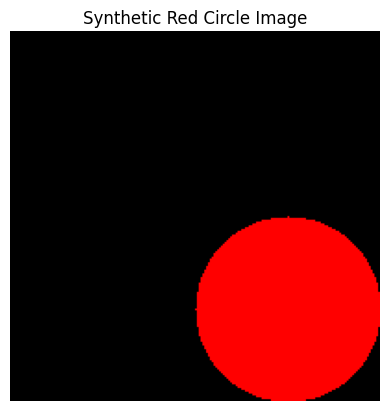

In [3]:
# Display the synthetic image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Synthetic Red Circle Image')
plt.axis('off')
plt.show()

Next, convert the image to HSV color space and threshold to isolate red pixels. We use a HSV range that captures the red hue.

In [4]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# Define HSV range for red color (tune these values if needed)
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
mask = cv2.inRange(hsv, lower_red, upper_red)
print("Applied HSV threshold for red. Nonzero mask pixels:", np.sum(mask>0))

Applied HSV threshold for red. Nonzero mask pixels: 7843


In [5]:
# Find contours in the mask to locate the red object
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    cnt = contours[0]
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    else:
        cx, cy = None, None
    print(f"Detected center at pixel coordinates: ({cx}, {cy})")
else:
    cx, cy = None, None
    print("No red object detected.")

Detected center at pixel coordinates: (149, 149)


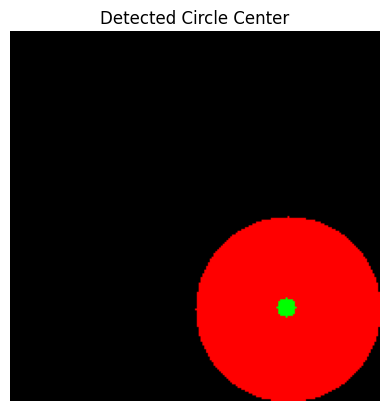

In [6]:
# Draw the detected center on the image for visualization
display_image = image.copy()
if cx is not None:
    cv2.circle(display_image, (cx, cy), 5, (0, 255, 0), -1)  # green dot
plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Circle Center')
plt.axis('off')
plt.show()

Now we map the pixel coordinates `(cx, cy)` to world coordinates. We assume the image covers a 1m×1m plane. Pixel `(0,0)` maps to world `(-0.5m, -0.5m)`, and pixel (width, height) maps to `(0.5m, 0.5m)`. The formula scales and offsets accordingly.

In [7]:
image_height, image_width = image.shape[:2]
plane_size = 1.0  # in meters
world_x = (cx / image_width) * plane_size - plane_size/2
world_y = (cy / image_height) * plane_size - plane_size/2
print(f"Mapped to world coordinates: x = {world_x:.2f} m, y = {world_y:.2f} m (z=0 assumed)")

Mapped to world coordinates: x = 0.24 m, y = 0.24 m (z=0 assumed)


To verify the mapping formula, consider example corners:

In [8]:
# Example: pixel (0,0) and (width-1, height-1) mapping
px, py = 0, 0
wx = (px / image_width) * plane_size - plane_size/2
wy = (py / image_height) * plane_size - plane_size/2
print(f"Pixel (0,0) → World ({wx:.2f}, {wy:.2f})")

px, py = image_width-1, image_height-1
wx = (px / image_width) * plane_size - plane_size/2
wy = (py / image_height) * plane_size - plane_size/2
print(f"Pixel ({px},{py}) → World ({wx:.2f}, {wy:.2f})")

Pixel (0,0) → World (-0.50, -0.50)
Pixel (199,199) → World (0.49, 0.49)


We now set up the PyBullet simulation. We load a plane and a KUKA robot arm.

<img src="https://i.postimg.cc/QNKrQSzx/Screenshot-2025-06-12-at-1-28-38-AM.png" alt="Sample Image" width="200"/>

In [9]:
# [COLAB USERS ONLY]
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = p.loadURDF("plane.urdf")
print("Loaded PyBullet plane.")

Loaded PyBullet plane.


In [ ]:
# [LOCAL USERS - PLEASE TRANSFER THE FOLLOWING CODE TO A SEPARATE PYTHON FILE!]
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = p.loadURDF("plane.urdf")
print("Loaded PyBullet plane.")

In [10]:
# Load a KUKA robot arm at the origin
kukaId = p.loadURDF("kuka_iiwa/model.urdf", basePosition=[0,0,0], useFixedBase=True)
num_joints = p.getNumJoints(kukaId)
print(f"Loaded KUKA with {num_joints} joints.")

Loaded KUKA with 7 joints.


We place a small red sphere at the detected world coordinates to mark the target.

In [11]:
sphereRadius = 0.05
colSphereId = p.createCollisionShape(p.GEOM_SPHERE, radius=sphereRadius)
visSphereId = p.createVisualShape(p.GEOM_SPHERE, radius=sphereRadius, rgbaColor=[1, 0, 0, 1])
sphereId = p.createMultiBody(baseMass=0, baseCollisionShapeIndex=colSphereId,
                             baseVisualShapeIndex=visSphereId,
                             basePosition=[world_x, world_y, sphereRadius])
print("Sphere placed at world coordinates:", (world_x, world_y))

Sphere placed at world coordinates: (0.245, 0.245)


Optionally, we can use inverse kinematics to move the KUKA’s end effector near the sphere. The end-effector link index for KUKA is typically 6 (last joint).

In [12]:
end_effector_index = 6
target_pos = [world_x, world_y, sphereRadius + 0.1]  # a bit above the sphere
joint_positions = p.calculateInverseKinematics(kukaId, end_effector_index, target_pos)
for j in range(num_joints):
    p.resetJointState(kukaId, j, joint_positions[j])
print("Moved KUKA end-effector near the target position.")


Moved KUKA end-effector near the target position.


In [13]:
# [COLAB USERS ONLY]: Step the simulation a few times (no visualization in DIRECT mode)
for _ in range(100):
    p.stepSimulation()
p.disconnect()
print("Simulation step completed and disconnected.")

Simulation step completed and disconnected.


In [ ]:
# [LOCAL USERS ONLY]: Run the simulation in an infinite loop so the program doesn't quit
while True:
    p.stepSimulation()
    time.sleep(0.01)
p.disconnect()
print("Simulation step completed and disconnected.")

Mask shape: (200, 200) Number of detected pixels: 7843


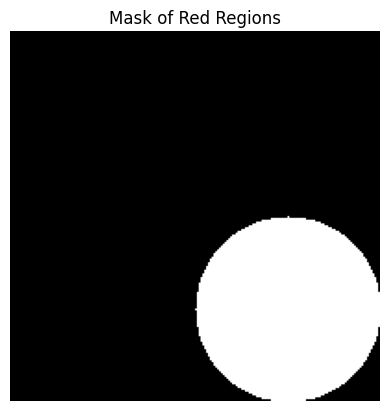

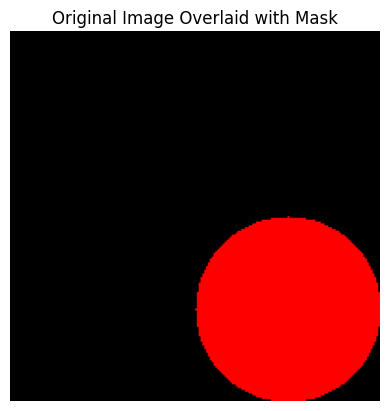

In [14]:
# Inspect the mask and overlays for clarity (debugging visuals):
print("Mask shape:", mask.shape, "Number of detected pixels:", np.sum(mask>0))
plt.imshow(mask, cmap='gray')
plt.title('Mask of Red Regions')
plt.axis('off')
plt.show()

overlay = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Original Image Overlaid with Mask')
plt.axis('off')
plt.show()


## Using Simulated Images

Below is a TopDownCamera class that abstracts away the complex details about camera calibration and making a camera at a certain position in PyBullet. Feel free to use this below!

Note for LOCAL USERS: copy the imports from the first cell and make a new python file to run :)

In [2]:
class TopDownCamera:

    def __init__(self, 
                 img_width: int,
                 img_height: int,
                 camera_position: list[float],
                 floor_plane_size: float,
                 ):
        """
        A TopDownCamera for use in the simulation to get images.

        Args:
            img_width: int, width of a gathered image in pixels
            img_height: int, height of a gathered image in pixels
            camera_position: list[float], position of the camera in world coordinates, [X, Y, Z]
            floor_plane_size: float, size of each side of the floor plane in meters (the camera is looking down on this plane)
        """
        self._img_width = img_width
        self._img_height = img_height
        self._floor_plane_size = floor_plane_size
        self._camera_position = camera_position
        
        # Roll, pitch, and yaw in degrees specify how the camera is rotated in the world (this makes it top-down)
        self._roll = 0
        self._pitch = -90
        self._yaw = 90

        camera_target = camera_position.copy()
        camera_target[2] = 0

        # Extrinsics matrix: camera position in world coordinates
        self._view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cameraTargetPosition=camera_target,
            distance=camera_position[2],
            yaw=self._yaw,
            pitch=self._pitch,
            roll=self._roll,
            upAxisIndex=2
        )

        self._aspect_ratio = img_width / img_height
        self._near = 0.01
        self._far = 10
        self._fov = 2 * np.degrees(np.arctan((floor_plane_size/2) / camera_position[2]))  # field of view to cover 1m

        # Intrinsics matrix
        self._projection_matrix = p.computeProjectionMatrixFOV(
            fov=self._fov,
            aspect=self._aspect_ratio,
            nearVal=self._near,
            farVal=self._far
        )

    def get_image(self):
        """
        Takes a RGB top-down image from inside Pybullet.

        Returns:
            rgb_img: np.ndarray, RGB image of shape (img_height, img_width, 3)
        """
        img_arr = p.getCameraImage(
            width=self._img_width,
            height=self._img_height,
            viewMatrix=self._view_matrix,
            projectionMatrix=self._projection_matrix,
        )
        rgba = np.reshape(img_arr[2], (self._img_height, self._img_width, 4))
        rgb_img = rgba[:, :, :3]
        return rgb_img
    
    def get_pixel_world_coords(self, pixel_x: int, pixel_y: int) -> list[float]:
        """
        Converts a pixel coordinate to 3D world coordinates assuming the pixel lies on the floor plane.

        Args:
            pixel_x: int, x-coordinate of the pixel
            pixel_y: int, y-coordinate of the pixel

        Returns:
            world_coords: list[float], 3D world coordinates of the pixel, [X, Y, Z]
        """
        world_x = (pixel_x / self._img_width) * self._floor_plane_size - self._floor_plane_size/2
        world_y = (pixel_y / self._img_height) * self._floor_plane_size - self._floor_plane_size/2
        world_z = 0
        return [world_x, world_y, world_z]

In [3]:
# Re-set up the simulation again, since it is closed
# [COLAB USERS ONLY]
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = p.loadURDF("plane.urdf")
print("Loaded PyBullet plane.")

Loaded PyBullet plane.


In [ ]:
# [LOCAL USERS - PLEASE TRANSFER THE FOLLOWING CODE TO A SEPARATE PYTHON FILE!]
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = p.loadURDF("plane.urdf")
print("Loaded PyBullet plane.")

In [4]:
# Load a KUKA robot arm at the origin
kukaId = p.loadURDF("kuka_iiwa/model.urdf", basePosition=[0,0,0], useFixedBase=True)
num_joints = p.getNumJoints(kukaId)
print(f"Loaded KUKA with {num_joints} joints.")

Loaded KUKA with 7 joints.


In [8]:
# Play around with these and see where the sphere ends up!
SPHERE_X = 0.25
SPHERE_Y = 0.25

sphereRadius = 0.05
colSphereId = p.createCollisionShape(p.GEOM_SPHERE, radius=sphereRadius)
visSphereId = p.createVisualShape(p.GEOM_SPHERE, radius=sphereRadius, rgbaColor=[1, 0, 0, 1])
sphereId = p.createMultiBody(baseMass=0, baseCollisionShapeIndex=colSphereId,
                             baseVisualShapeIndex=visSphereId,
                             basePosition=[SPHERE_X, SPHERE_Y, sphereRadius])
print("Sphere placed at world coordinates:", (SPHERE_X, SPHERE_Y))

Sphere placed at world coordinates: (0.25, 0.25)


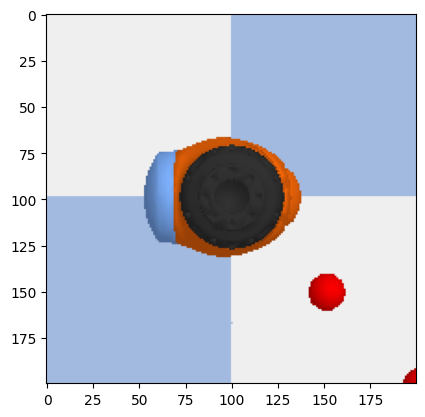

[0.25, 0.25, 0]


In [11]:
# How to use this camera?

# 1. Create a camera object
camera = TopDownCamera(
    img_width=200, 
    img_height=200, 
    camera_position=[0, 0, 2], 
    floor_plane_size=1.0
    )

# 2. Get an image and display it
img = camera.get_image()
plt.imshow(img)
plt.show()

# 3. Get the world coordinates of a pixel
world_coords = camera.get_pixel_world_coords(150, 150)
print(world_coords)

**🗣 Discussion & Reflection**

1. Mapping Accuracy: *If the red sphere appears offset in the PyBullet view, what could be wrong?*  
   - HSV threshold too tight or loose → centroid shifts  
   - Pixel‑to‑world scaling factor wrong (camera FOV assumption)  
   - Image center not perfectly aligned with world origin  

2. Food for Thought:
   - How would mapping change if the camera were **tilted** instead of perfectly top‑down?  
   - In a real lab, what **calibration procedure** would you use to learn the exact transform?  

3. Mini‑Exercise:
   - For the part before the Simulated Images: Move the red circle to three new pixel locations (e.g. (50,50), (150,50), (0,0)).  
   - Predict where the sphere should land in world (draw on paper), **then run** the notebook and confirm.

Assignment: Place the red sphere somewhere in the world, threshold appropriately, and make the robot go right above it!